In [1]:
import pandas as pd
from pysyncon import Dataprep, Synth

In [2]:
df = pd.read_csv("germany.csv")

dataprep_train = Dataprep(
    foo=df,
    predictors=["gdp", "trade", "infrate"],
    predictors_op="mean",
    time_predictors_prior=range(1971, 1981),
    special_predictors=[
        ("industry", range(1971, 1981), "mean"),
        ("schooling", [1970, 1975], "mean"),
        ("invest70", [1980], "mean"),
    ],
    dependent="gdp",
    unit_variable="country",
    time_variable="year",
    treatment_identifier="West Germany",
    controls_identifier=[
        "USA",
        "UK",
        "Austria",
        "Belgium",
        "Denmark",
        "France",
        "Italy",
        "Netherlands",
        "Norway",
        "Switzerland",
        "Japan",
        "Greece",
        "Portugal",
        "Spain",
        "Australia",
        "New Zealand",
    ],
    time_optimize_ssr=range(1981, 1991),
)

synth_train = Synth()
synth_train.fit(dataprep=dataprep_train)

In [3]:
dataprep = Dataprep(
    foo=df,
    predictors=["gdp", "trade", "infrate"],
    predictors_op="mean",
    time_predictors_prior=range(1981, 1991),
    special_predictors=[
        ("industry", range(1981, 1991), "mean"),
        ("schooling", [1980, 1985], "mean"),
        ("invest80", [1980], "mean"),
    ],
    dependent="gdp",
    unit_variable="country",
    time_variable="year",
    treatment_identifier="West Germany",
    controls_identifier=[
        "USA",
        "UK",
        "Austria",
        "Belgium",
        "Denmark",
        "France",
        "Italy",
        "Netherlands",
        "Norway",
        "Switzerland",
        "Japan",
        "Greece",
        "Portugal",
        "Spain",
        "Australia",
        "New Zealand",
    ],
    time_optimize_ssr=range(1960, 1990),
)

synth = Synth()
synth.fit(dataprep=dataprep, custom_V=synth_train.V)

In [4]:
synth.weights()

USA            0.216
UK             0.000
Austria        0.415
Belgium        0.000
Denmark        0.000
France         0.000
Italy          0.000
Netherlands    0.098
Norway         0.000
Switzerland    0.108
Japan          0.163
Greece         0.000
Portugal       0.000
Spain          0.000
Australia      0.000
New Zealand    0.000
Name: weights, dtype: float64

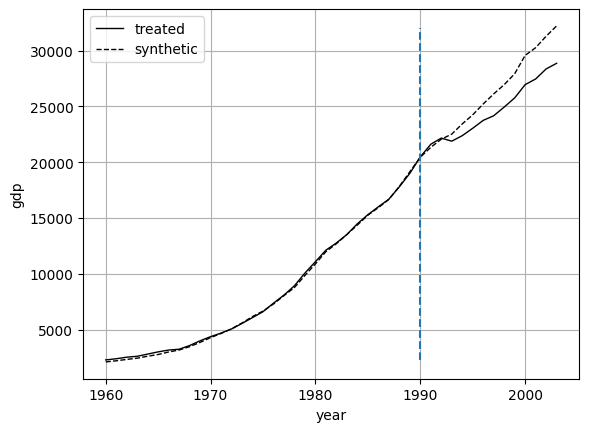

In [5]:
synth.path_plot(treatment_time=1990)

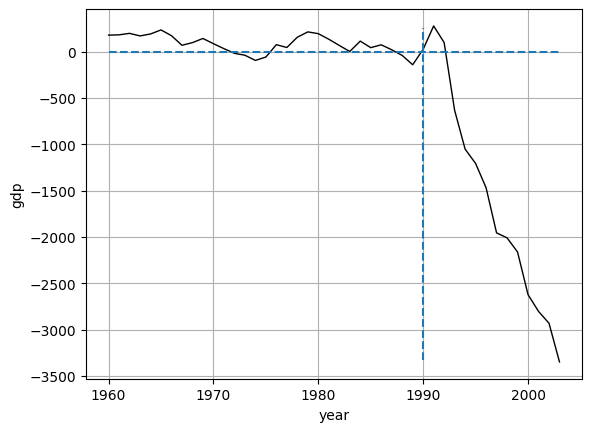

In [6]:
synth.gaps_plot(treatment_time=1990)

In [7]:
synth.summary()

,V,treated,synthetic,sample mean
gdp,0.240,15808.900,15777.800,13669.381
trade,0.205,56.778,56.980,59.831
infrate,0.188,2.595,3.441,7.617
special.1.industry,0.001,34.538,34.436,33.794
special.2.schooling,0.208,55.500,55.103,38.659
special.3.invest80,0.158,27.018,27.074,25.895
